<a href="https://colab.research.google.com/github/BrunnoRicci/op-art-gan/blob/master/opa_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [0]:
#@title import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import datetime

import os

#CV libs
from PIL import Image 
from IPython.display import Image as IPMage

#Display Settings
pw = 12
ph = 8
matplotlib.rcParams['figure.figsize'] = (pw, ph)
plt.rcParams.update({'font.size': 14})

sns.set_style("whitegrid")
plt.style.use('seaborn-white')

from google.colab import drive
drive.mount('/content/drive')

import pickle

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#@title constants

#Colors
aqua = '#5cd1e0'
peach = '#f2b75e'
blue = '#4cbcf5'
pink = '#ff75c1'
gray = '#adadad'
coral = '#ff6370'
plum = '#c362e3'
sblue = '#577bff'

#Image
iw = 128
ih = 128
nc = 3

## Prepprocess Images

In [0]:
#@title Preprocess Scarped Images
def crop_central_square(image):
  width, height = image.size
  #Check if square
  if width == height:
    return image
  elif width < height:
    left, right = 0, width
    upper = int((height - width) / 2)
    lower = upper + width
  else:
    upper, lower = 0, height
    left = int((width - height) / 2)
    right = left + height
  #Crop
  return image.crop((left, upper, right, lower))

scraped_path = '/content/drive/My Drive/Colab Notebooks/OPArt/Scraped Images'
input_path = '/content/drive/My Drive/Colab Notebooks/OPArt/Input Images'

image_names = os.listdir(scraped_path)

for i, image_name in enumerate(image_names):
  continue
  #Read
  image = Image.open(scraped_path + '/' + image_name)
  #Crop central square
  image = crop_central_square(image)
  #Resize
  image = image.resize((iw,ih))
  #Output image
  image.save(input_path + '/' + image_name)
  
  if i % 50 == 0:
     print("Processed ", i + 1)
      
print("Processed ", i + 1, "\n\rDone!")

Processed  1079 
Done!


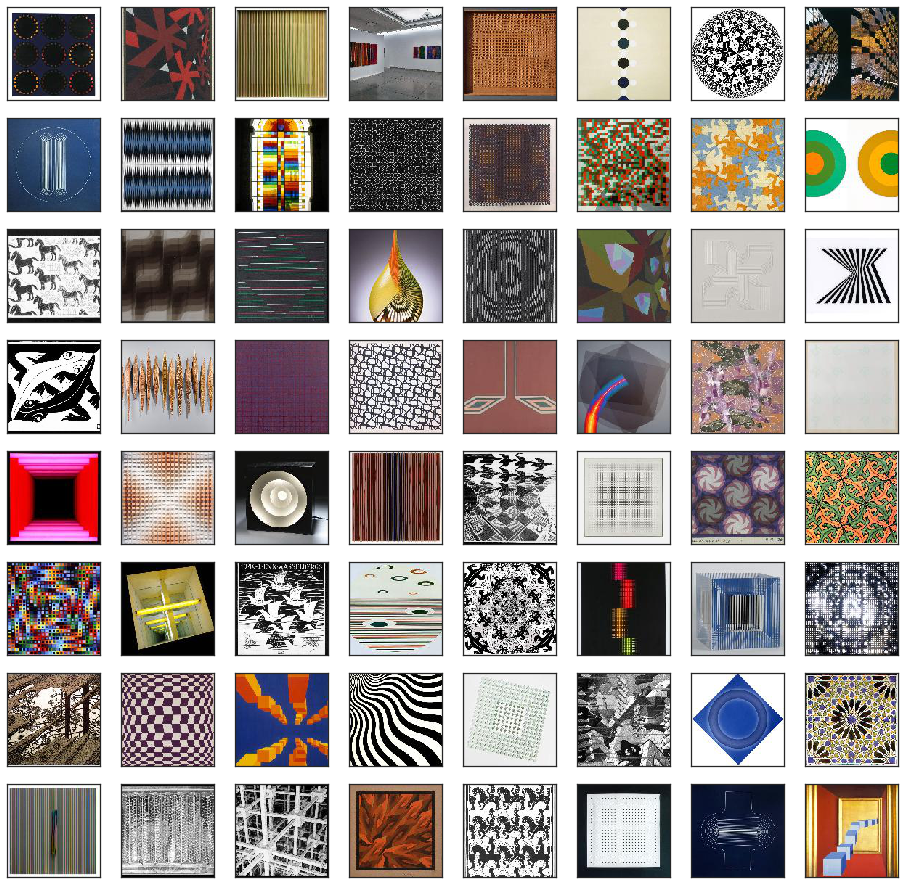

In [0]:
#@title Display Images
%%capture --no-display

def display_images(images, col_width = 5):
    col_height = int(np.ceil(len(images) / col_width))
    f, axs = plt.subplots(col_height, col_width, figsize=(col_width * 2, col_height * 2))
    for i, image in enumerate(images):
        ax = axs[i // col_width, i % col_width]
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])
      

n_to_disp = 64
np.random.seed(23)
to_disp = np.random.choice(np.arange(len(image_names)), n_to_disp, replace=False)

images = [Image.open(input_path + '/' + image_names[td]) for td in to_disp]
display_images(images, int(np.sqrt(n_to_disp)))

## Model

In [0]:
#@title import TF
%tensorflow_version 2.x

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

tf.__version__

'2.0.0'

In [0]:
#import glob
import time
#import imageio

from tensorflow.keras import layers
from IPython import display

In [0]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13214652592886141758, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2051821419840847230
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2170524372488169350
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11330115994
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16010777901582160448
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

## Prepare Images

In [0]:
#@title prepare images
images = np.empty([len(image_names), iw, ih, nc])

i = 0 
for image_name in image_names:
  image_path = input_path + '/' + image_name
  #Load image
  im = Image.open(image_path)
  np_im = np.asarray(im)
  #Not color image
  if np_im.shape[-1] != nc:
    continue
  #Save image
  images[i] = np_im
  i += 1
  
  if i % 50 == 0:
    print("Processed ", i + 1)
      
print("Processed ", i + 1, "\n\rDone!")

#Drop empty slots
images = images[:i]

#Normalize Images
images = (images - 127.5) / 127.5

Processed  51
Processed  101
Processed  151
Processed  201
Processed  251
Processed  301
Processed  351
Processed  401
Processed  451
Processed  501
Processed  551
Processed  601
Processed  651
Processed  701
Processed  751
Processed  801
Processed  851
Processed  901
Processed  951
Processed  1001
Processed  1039 
Done!


## Train

In [0]:
#@title dump/load images from GD

file_path = '/content/drive/My Drive/Colab Notebooks/OPArt/images.dump'

#Dump
# with open(file_path, 'wb') as f:
#   pickle.dump(images, f) 

#Load
with open(file_path, 'rb') as f:
  images = pickle.load(f) 

In [0]:
#Params
BUFFER_SIZE = len(images) * 2
BATCH_SIZE = 8

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*2048, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 2048)))
    assert model.output_shape == (None, 4, 4, 2048) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(1024, (4, 4), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 4, 4, 1024)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(512, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)

    return model

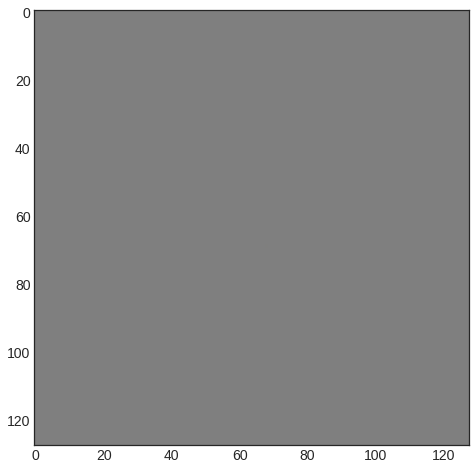

In [0]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

topl = np.array(generated_image[0, :, :, :])
topl = (topl + 1) / 2

plt.imshow(topl);

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same',
                                     input_shape=[iw, ih, nc]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.1))

    
    model.add(layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.1))


    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [0]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-5.8037305e-05]], shape=(1, 1), dtype=float32)


In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/OPArt/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(12,12))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(np.uint8(predictions[i, :, :, :] * 127.5 + 127.5), cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    #train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [0]:
EPOCHS = 100

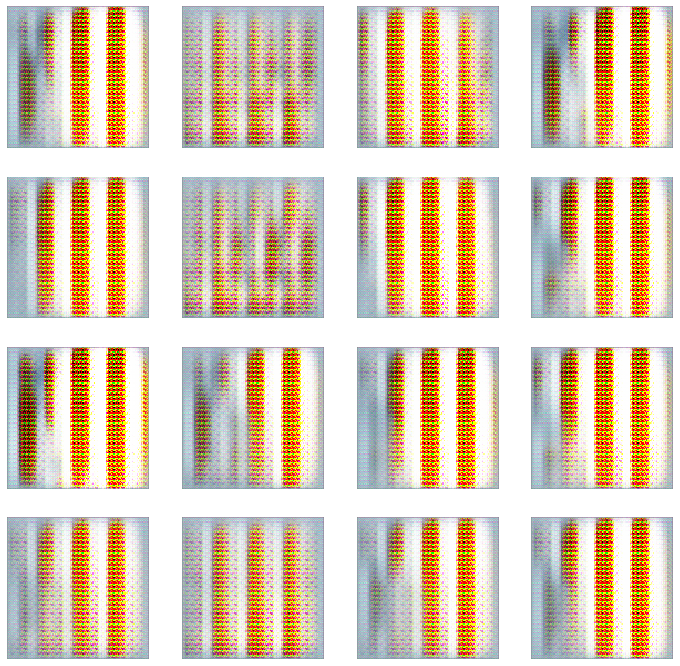

Time for epoch 6 is 25.84022879600525 sec


In [0]:
%%time
train(train_dataset, EPOCHS)

In [0]:
noise = tf.random.normal([1, noise_dim], seed=64)

  
image = generator(noise, training=False)
plt.imshow(np.uint8(image[0] * 127.5 + 127.5), cmap='gray');

In [0]:
print(discriminator(image))

In [0]:
# To generate GIFs
%%capture
!pip install -q imageio

In [0]:
import glob
import imageio

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

# import IPython
# if IPython.version_info > (6,2,0,''):
#   display.Image(filename=anim_file)

In [0]:
files.download(anim_file)

In [0]:
#@title Download epoch files
from google.colab import files
for en in range(11,99):
  files.download('image_at_epoch_00{:02d}.png'.format(en)) 